# Model Selection

Here, I wanted to find the best model (the one that minimizes the RMSLE). For speed and simplicity, I only used the default models (i.e., no hyperparameter tuning).

## Summmary
 - The **CatBoostRegressor is the best model** in terms of minimizing the RMSLE (RMSLE = 0.162328)
 - While regressors result in lower RMSLE, they only predict values between 4 and ~20 rings, while the range of rings in the train set is 1 to 29); this is because there are many more observations in this range ( 5 to 20 rings) and thus regressors learn that its safer to make such predictions
  - I think **classifiers would be better in reality** because they can also find the age of very young and very old abalones (<5 and >20 rings)

## Sections
1. Import Libraries and Data
2. Prepare Data
3. Cross Validation and Predictions
4. Visualise Predictions

#### 1. Import Libraries and Data

In [8]:
# Data exploration and manipulation
import pandas as pd
import numpy as np

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# # Models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# # Validation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer,root_mean_squared_log_error 

In [9]:
# I am using preprocessed datasets (see preprocessing.ipynb for more info)
train_mod = pd.read_csv('data/train_preprocessed.csv', index_col = "id")
test_mod = pd.read_csv('data/test_preprocessed.csv', index_col = "id")

In [10]:
train_mod.tail(3)

,Length,Height,Whole weight,Sex_I,Sex_M,DimensionsCluster,Rings
id,,,,,,,
90612,0.435,0.095,0.3215,1,0,1,6
90613,0.345,0.075,0.2000,1,0,1,6
90614,0.425,0.100,0.3455,1,0,1,8


In [11]:
test_mod.head(3)

,Length,Height,Whole weight,Sex_I,Sex_M,DimensionsCluster
id,,,,,,
90615,0.645,0.155,1.2380,0,1,2
90616,0.580,0.160,0.9830,0,1,0
90617,0.560,0.140,0.8395,0,1,0


#### 2. Prepare Data

In [12]:
# Prepare feature and taget sets
X = train_mod.iloc[:,:-1]  # features set
y = train_mod.iloc[:,-1]  # target set

# modify targets for classification
y_clf = y - 1 # classes have to start from 0 for xgbclassifier
y_clf[y_clf==28] = 27 # class 28 is missing from the data; here I am fixing this or the xgbclassifier wouldn't work

#### 3. Cross validation and predictions

In [13]:
models_list = [RandomForestRegressor(),XGBRegressor(),RandomForestClassifier(),XGBClassifier(),LGBMClassifier(verbosity=-1),CatBoostRegressor(verbose = False)]
performance_dict = {}
predictions_dict = {}

In [14]:
for mdl in models_list:
    
    model_name = mdl.__class__.__name__
    print("Running " + model_name + "...")
    
    # set up data
    X_ = X # feature set for all models
    y_ = y # target set for regressors
    
    if model_name == "XGBClassifier":
        y_ = y_clf  # target set for classifiers
        
        
    # Create a scoring method
    rmsle_scorer = make_scorer(root_mean_squared_log_error)

    
    # perform cross validation
    cv_rmsle = cross_val_score(estimator = mdl, X=X_, y=y_, cv = 5, scoring = rmsle_scorer)
    performance_dict[model_name] = [cv_rmsle.mean(), cv_rmsle.std()]
    print(model_name + ' mean cv score:', cv_rmsle.mean())
    print(model_name +' std cv score:', cv_rmsle.std())
    print()
    
    #make predictions
    y_pred = mdl.fit(X,y_).predict(test_mod)
    
    
    # Postprocessing predictions
    
    # reverse the operation made on y_clf for classifiers
    if model_name == "XGBClassifier":
        y_pred = y_pred + 1 
        
    # we don't have a class 28. Hence, post-processing for class 28 helps the score
    y_pred = np.where((y_pred >= 27.5) & (y_pred <= 29), 29, y_pred)
    
    predictions_dict[model_name] = y_pred

Running RandomForestRegressor...
RandomForestRegressor mean cv score: 0.1979558661721795
RandomForestRegressor std cv score: 0.0012860989987789509

Running XGBRegressor...
XGBRegressor mean cv score: 0.17951422130188255
XGBRegressor std cv score: 0.0016298177424165763

Running RandomForestClassifier...
RandomForestClassifier mean cv score: 0.23863909253099166
RandomForestClassifier std cv score: 0.0009894633786183406

Running XGBClassifier...
XGBClassifier mean cv score: 0.22987749822408937
XGBClassifier std cv score: 0.0016811713379088907

Running LGBMClassifier...
LGBMClassifier mean cv score: 0.36235125509933475
LGBMClassifier std cv score: 0.05993726787067311

Running CatBoostRegressor...
CatBoostRegressor mean cv score: 0.17822074422797293
CatBoostRegressor std cv score: 0.001609413085486121



In [16]:
#save predictions and performance
predictions_df = pd.DataFrame(predictions_dict, index = test_mod.index)
performance_df = pd.DataFrame(performance_dict, index = ['mean_rmsle','std_rmsle'])

predictions_df.to_csv('data/predictions_df_notuning.csv')
performance_df.to_csv('data/performance_df_notuning.csv')

#### 4. Visualize predictions

In [18]:
predictions_df = pd.read_csv('data/predictions_df_notuning.csv', index_col = "id")
performance_df = pd.read_csv('data/performance_df_notuning.csv', index_col = 0)

In [19]:
predictions_df.head(3)

,RandomForestRegressor,XGBRegressor,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostRegressor
id,,,,,,
90615,9.989167,9.781983,9,9,10,9.867979
90616,10.566167,11.092540,9,9,8,11.249176
90617,9.648167,10.049815,10,9,12,10.138059


In [20]:
performance_df.head(3)

,RandomForestRegressor,XGBRegressor,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostRegressor
mean_rmsle,0.197956,0.179514,0.238639,0.229877,0.362351,0.178221
std_rmsle,0.001286,0.001630,0.000989,0.001681,0.059937,0.001609


**The best model is the CatBoostRegressor with mean rmsle of 0.178**

In [21]:
# Add the predictions to the test set
predictions_full = test_mod.merge(predictions_df, left_index = True, right_index = True)
predictions_full.iloc[:,5:] = round(predictions_full.iloc[:,5:],0)

In [22]:
predictions_full.head()

,Length,Height,Whole weight,Sex_I,Sex_M,DimensionsCluster,RandomForestRegressor,XGBRegressor,RandomForestClassifier,XGBClassifier,LGBMClassifier,CatBoostRegressor
id,,,,,,,,,,,,
90615,0.645,0.155,1.2380,0,1,2,10.0,10.0,9,9,10,10.0
90616,0.580,0.160,0.9830,0,1,0,11.0,11.0,9,9,8,11.0
90617,0.560,0.140,0.8395,0,1,0,10.0,10.0,10,9,12,10.0
90618,0.570,0.145,0.8740,0,1,0,12.0,10.0,13,9,10,10.0
90619,0.415,0.110,0.3580,1,0,1,7.0,8.0,7,7,10,8.0


##### 4.1. Predicted Targets vs Features

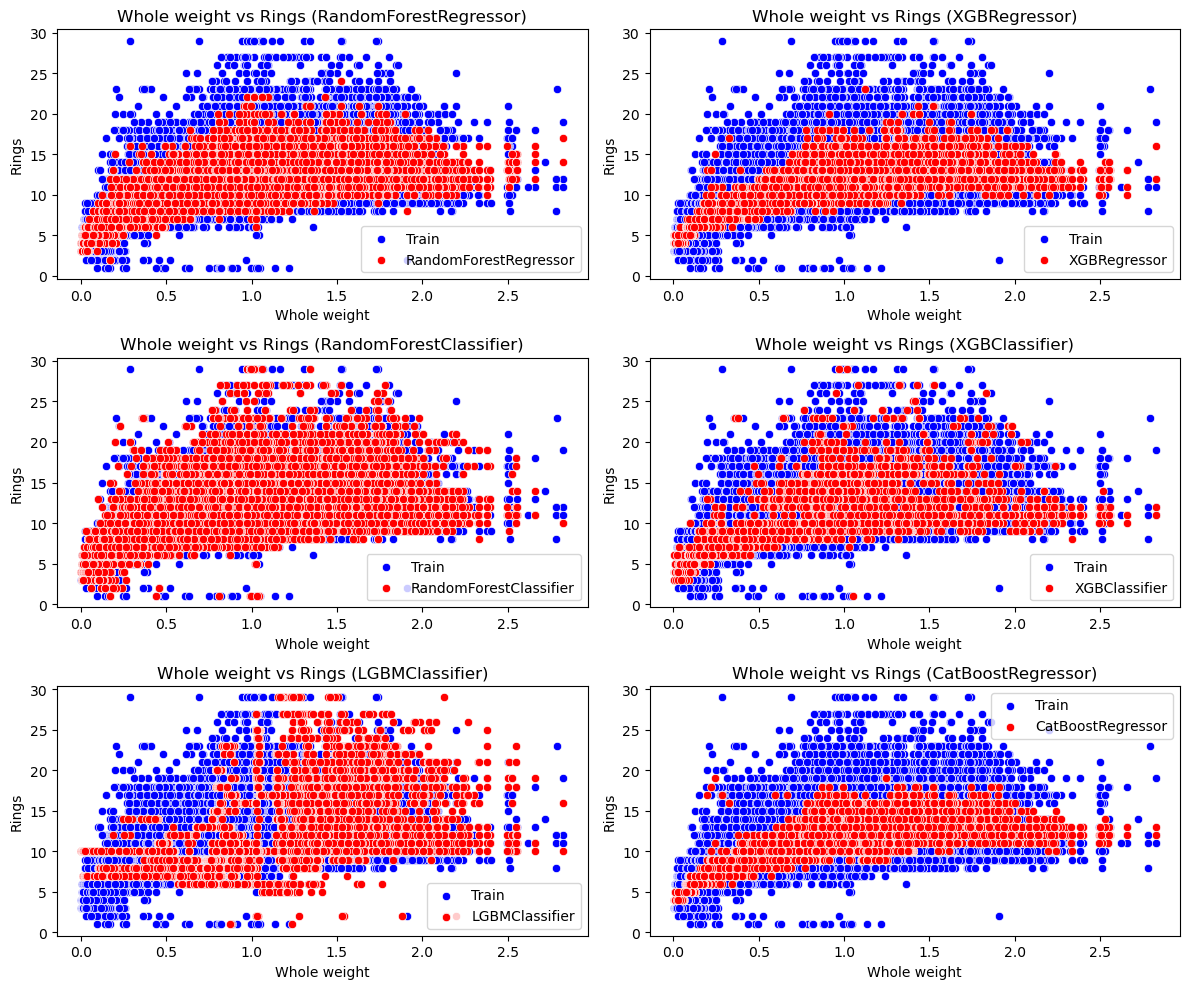

In [23]:
# Select feature to plot against the target
feature = 'Whole weight'

# Create a new figure with a 2x2 grid layout
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

# Iterate over each model and subplot position
for i, model in enumerate(predictions_df.columns):
    # Determine the position of the subplot in the grid
    row = i // 2
    col = i % 2
    
    # Plot Diameter vs Rings for train_mod in blue
    sns.scatterplot(x=feature, y='Rings', data=train_mod, color='blue', label='Train', ax=axs[row, col])

    # Plot Diameter vs Rings for predictions_full in red
    sns.scatterplot(x=feature, y=model, data=predictions_full, color='red', label=model, ax=axs[row, col])

    # Add title and labels
    axs[row, col].set_title(f'{feature} vs Rings ({model})')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Rings')
    axs[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The plots above show that regressors make predictions quite homogeneously concentrated in the mid-range of rings (5 to 20 rings) which is where most observations in the train set are. **Classifiers on the other hand, can predict the full range (between 1 and 29)**, which might be better in real life

##### 4.2. Average feature vs predicted targets

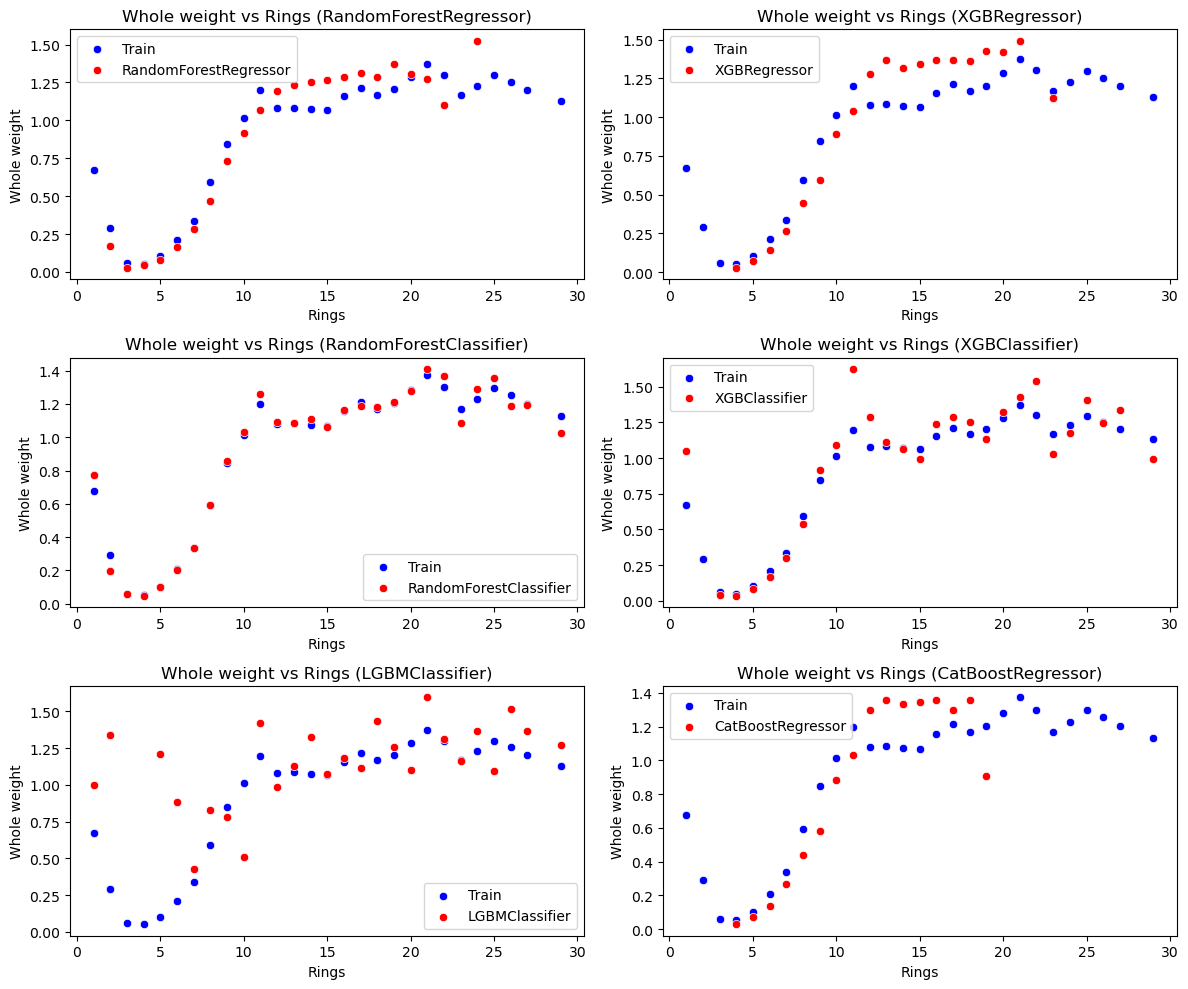

In [24]:
# Select feature to plot against the target
feature = 'Whole weight'

# Create a new figure with a 2x2 grid layout
fig, axs = plt.subplots(3, 2, figsize=(12, 10))

#group train data by Rings
train_grouped = train_mod.groupby('Rings', as_index = False).mean(numeric_only = True)
    
# Iterate over each model and subplot position
for i, model in enumerate(predictions_df.columns):
    # Determine the position of the subplot in the grid
    row = i // 2
    col = i % 2
    
    # Plot Rings vs feature for train_grouped in blue
    sns.scatterplot(y=feature, x='Rings', data=train_grouped, color='blue', label='Train', ax=axs[row, col])

    # Plot Diameter vs Rings for predictions_full in red
    predictions_grouped = predictions_full.groupby(model, as_index = False).mean(numeric_only = True)
    sns.scatterplot(y=feature, x=model, data=predictions_grouped, color='red', label=model, ax=axs[row, col])

    # Add title and labels
    axs[row, col].set_title(f'{feature} vs Rings ({model})')
    axs[row, col].set_ylabel(feature)
    axs[row, col].set_xlabel('Rings')
    axs[row, col].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

The above plots show that classifier make better predictions on average (the plots are more similar to the real observations in the train set); however, the regressors do result in better RMSLE.